In [1]:
from qiskit import QuantumCircuit,  QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.library import QFT, MCMT, XGate
from numpy import pi
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
import numpy as np


## Moneta Grovera

Monetę Grovera buduje się korzystając z części tego algorytmu  - Inversji. Ta część zwana jest też dyfuzją, ponieważ może słuzyc do "rozprzestrzeniania się" po przestrzeni stanów.

In [2]:
# ogólna funckcja tworząca obwód dyfuzji Grovera (z tutorialu qiskita)
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits, name="Diffuser")
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.compose(MCMT(XGate(), nqubits-1, 1), inplace=True)
   # qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    return qc

Jak widać dla n=3 moneta Grovera zawiera te same wartości (0.25) poza diagonalą, oraz te same wartości (-0.75) na diagonali

In [3]:
import qiskit.quantum_info as qi
op = -qi.Operator(diffuser(3))
op

Operator([[-0.75+0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,
            0.25-0.j,  0.25-0.j,  0.25-0.j],
          [ 0.25-0.j, -0.75+0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,
            0.25-0.j,  0.25-0.j,  0.25-0.j],
          [ 0.25-0.j,  0.25-0.j, -0.75+0.j,  0.25-0.j,  0.25-0.j,
            0.25-0.j,  0.25-0.j,  0.25-0.j],
          [ 0.25-0.j,  0.25-0.j,  0.25-0.j, -0.75+0.j,  0.25-0.j,
            0.25-0.j,  0.25-0.j,  0.25-0.j],
          [ 0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j, -0.75+0.j,
            0.25-0.j,  0.25-0.j,  0.25-0.j],
          [ 0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,
           -0.75+0.j,  0.25-0.j,  0.25-0.j],
          [ 0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,
            0.25-0.j, -0.75+0.j,  0.25-0.j],
          [ 0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,  0.25-0.j,
            0.25-0.j,  0.25-0.j, -0.75+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))


Podobnie do monety  Hadamarda, moneta Grovera  umieszcza wędrownika w superpozycji. 
Róznice:
* dla n>2 nie jest to superpozycja o jednakowych amplitudach.  Generalnie superpozycja po monecie Grovera daje większe prawdopodobieństwo zostania w stanie, w którym byliśmy  przed wykonaniem kroku
* moneta Grovera, (inaczej niż Hadamarda) jest symetryczna przy  przechodzeniu ze stanu |x> do innego stanu |y> 
(jak pamiętacie z poprzedniego labolatorium moneta  H  zachowuje się inaczej przy przechodzieniu z |0> niz przy przechodzeniu z |1>), tutaj dzięki symetrii moneta zachowuje się  tak samo we wszystkich kierunkach (poza zostaniem w miejscu)
* można pokazać, że moneta Grovera jest najlepszą  symetryczną unitarną monetą [Quantum random-walk search algorithm
Neil Shenvi, Julia Kempe, and K. Birgitta Whaley
Phys. Rev. A 67, 052307 – Published 23 May 2003 https://arxiv.org/pdf/quant-ph/0210064.pdf]


In [4]:
meas = QuantumCircuit(3,3)
meas.barrier(range(3))
meas.measure(range(3), range(3))

qc = meas.compose(diffuser(3), range(3), front=True)

#drawing the circuit
qc.draw()

┌───┐┌───┐          ┌───┐┌───┐      ░ ┌─┐      
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤M├──────
     ├───┤├───┤       │  ├───┤├───┤      ░ └╥┘┌─┐   
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├───
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════════════════════════╩══╩══╩═
                                            0  1  2

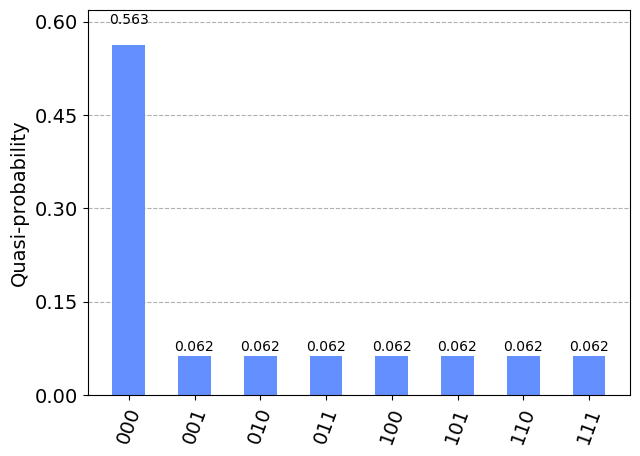

In [5]:
from qiskit.primitives import Sampler as PSampler
# jeśli do funkcji run() przekażemy tylko obwód to zwróci rezultat z wyliczonymi dokładnymi
#prawdopodobieństwami
results = PSampler().run(qc).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

Do celów labolatorium będziemy używać monety $2|s\rangle\langle s|-1$ z tutorialu qiskit dla dwóch qbitów https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm#2qubits

In [6]:
def diffuser2():
    qc = QuantumCircuit(2, name="Diffuser2")
    qc.h([0,1])
    qc.z([0,1])
    qc.cz(0,1)
    qc.h([0,1])
    return qc

## Krok na 4 wymiarowym hyperszescianie 

Na labolatorium użyjemy algorytmu poszukiwania za pomocą bładzenia na grafie będącym 4-wymiarowym hiperszescianem



Budujemy bramkę kroku.

Chodzimy po 4 wymiarowym hypercubie, więc ruszamy się tylko po najbliższych sąsiadach (czyli takich których pozycje róznią się na tylko jednym qbicie)

* Jeśli moneta jest w stanie |11> zmianiamy trzeci bit pozycji (q3)
* Jeśli moneta jest w stanie |10> zmianiamy drugi bit pozycji (q2)
* Jeśli moneta jest w stanie |01> zmianiamy pierwszy bit pozycji (q1)
* Jeśli moneta jest w stanie |00> zmianiamy zerowy bit pozycji (q0)

Jest to realizowane poprzez bramki Toffoliego obłożone odpowiednimi bramkami NOT, z tym, że  bramki NOT następujące po bezpośrednio po sobie zostały usunięte (patrz filmik).
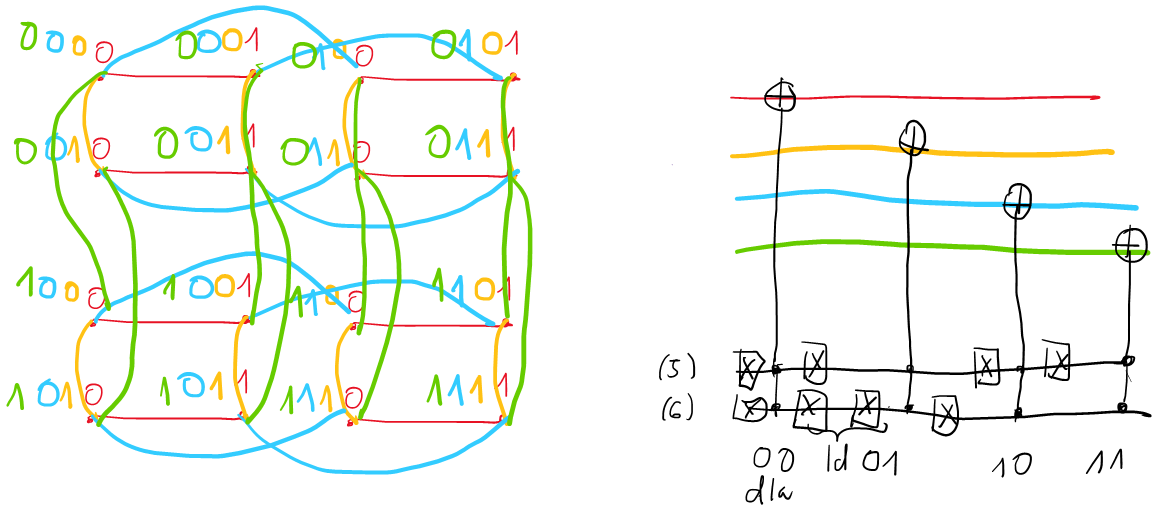



In [7]:
# Shift operator function for 4d-hypercube
przyklad2 = QuantumCircuit(7) 
def shift_operator(circuit):
    circuit.barrier()
    for i in range(0,4):
        circuit.x(5)
        if i%2==0:
            circuit.x(6)
        circuit.ccx(5,6,i)
 

shift_operator(przyklad2)
# cały obwód dla pierwszego kroku:
przyklad2.draw()

░      ┌───┐                              
q_0: ─░──────┤ X ├──────────────────────────────
      ░      └─┬─┘     ┌───┐                    
q_1: ─░────────┼───────┤ X ├────────────────────
      ░        │       └─┬─┘     ┌───┐          
q_2: ─░────────┼─────────┼───────┤ X ├──────────
      ░        │         │       └─┬─┘     ┌───┐
q_3: ─░────────┼─────────┼─────────┼───────┤ X ├
      ░        │         │         │       └─┬─┘
q_4: ─░────────┼─────────┼─────────┼─────────┼──
      ░ ┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐  │  
q_5: ─░─┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──
      ░ ├───┤  │  └───┘  │  ├───┤  │  └───┘  │  
q_6: ─░─┤ X ├──■─────────■──┤ X ├──■─────────■──
      ░ └───┘               └───┘

### Zmodyfikowana moneta do celów poszukiwań.

Do algorytmu poszukiwania potrzebna nam będzi moneta "wskazująca" właściwy wierzchołek 

taką jest kontrolowana moneta
$G\otimes|0\rangle\langle 0|-I \otimes |1\rangle\langle 1| $

* aplikujemy wyrocznię ((do celów demo użyjemy wierzchołka |1111>) ) sprawdzającą, czy jesteśmy we właściwym wierzchołku, rejestr wyjściowy wyroczni staje się bitem kontrolnym dla monety
* Jeśli bit kontrolny jest wyłączony (nie jesteśmy we własciwym wierzchołku)  aplikujemy  monetę Grovera (czyli idziemy dalej), 
* jeśli bit kontrolny jest włączony (jesteśmy we własciwym wierzchołku)- zostajemy, ale podobnie jak w algorytmie Grovera, zmieniamy  fazę (tutaj aplikujemy -I na qbitach targetu)- można to zaimplementować za pomocą bramki Z na qbicie kontrolnym

 Algorytm opisany jest w sekcji IIIA pracy https://arxiv.org/pdf/quant-ph/0210064.pdf

In [8]:
przyklad1= QuantumCircuit(7) 
def coin_operator(circuit):
    circuit.barrier()
# wyrocznia na 1111
    circuit.mcx([0,1,2,3],4)
# kontrolowana bramka -I
    circuit.z(4)
# kontrolowana dyfuzja
    circuit.x(4)
    dif =diffuser2().to_gate().control(1)
    circuit.append(dif, [4,5,6])
    circuit.x(4)
    
coin_operator(przyklad1)
przyklad1.draw()

░                                   
q_0: ─░───■───────────────────────────────
      ░   │                               
q_1: ─░───■───────────────────────────────
      ░   │                               
q_2: ─░───■───────────────────────────────
      ░   │                               
q_3: ─░───■───────────────────────────────
      ░ ┌─┴─┐┌───┐┌───┐              ┌───┐
q_4: ─░─┤ X ├┤ Z ├┤ X ├──────■───────┤ X ├
      ░ └───┘└───┘└───┘┌─────┴──────┐└───┘
q_5: ─░────────────────┤0           ├─────
      ░                │  Diffuser2 │     
q_6: ─░────────────────┤1           ├─────
      ░                └────────────┘

In [9]:
import qiskit
qiskit.version.get_version_info()

'1.0.1'

In [10]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.21.1'

### Zadanie

Zaimplementuj kwantowe poszukiwanie na 4-wymiarowym hypersześcianie wg pracy (https://arxiv.org/pdf/quant-ph/0210064.pdf) w następujacy sposób:

* qbity 0..3 kodują  pozycję na hiperszescianie (1 qbit=1 wymiar)
* qbit 4 jest qbitem kontrolnym dla wyroczni
* qbity 5 i 6 kodują czterostronną monetę - dwuqbitowy stan monety steruje czteroqbitowym krokiem

Algorytm:
 * ustawiamy qbity monety i qbity pozycji w superpozycji (bramki H na qbitach [0,1,2,3,5,6] (bez 4))
 * dokonujemy $\frac{\pi}{2}\sqrt{2^{n-1}}$ kroków (n- liczba wymiarów hypercuba, uwaga na $n-1$ !):
     * rzucamy monetą
     * robimy krok
 * powinniśmy dostać szukany stan z prawopodobieńswem $\frac{1}{2}-O(\frac{1}{n})$